# Testing How Best To Determine Point Removal

In [1]:
import os
import tsplib95
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import signal
import tqdm
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import *


from wsp import tsp, ds

FILE_DIR = "DATA_GEN_20p0.25"
AX = np.array([None, None])
S_FACTOR = 8.0
S_FACTOR_B = 2.0
TREE_TYPE = ds.PKPRQuadTree

In [2]:
top_problems = sorted(os.listdir(FILE_DIR))

len(top_problems)

5000

## Problem Injestion

In [3]:
base_df = pd.DataFrame(columns=['name', 'parent', 'path_reduction', 'path_discount', 'optimal_percent', 'wsp_reduction', 'wsp_reduction_B', 'point_specific_wsp', 'point_specific_wsp_B', 'point_specific_wsp_weighted', 'point_specific_wsp_weighted_B', 'point_average_cost', 'point_maximum_cost', 'point_minimum_cost', 'point_average_cost_weighted', 'point_maximum_cost_weighted', 'point_minimum_cost_weighted'])
base_df = base_df.astype({'name': str, 'parent': str, 'path_reduction': float, 'path_discount': float, 'optimal_percent': float, 'wsp_reduction': float, 'wsp_reduction_B': float, 'point_specific_wsp': float, 'point_specific_wsp_B': float, 'point_specific_wsp_weighted': float, 'point_specific_wsp_weighted_B': float, 'point_average_cost': float, 'point_maximum_cost': float, 'point_minimum_cost': float, 'point_average_cost_weighted': float, 'point_maximum_cost_weighted': float, 'point_minimum_cost_weighted': float})
base_df.set_index('name', inplace=True)

In [4]:
removed_problems : list[tsplib95.models.StandardProblem] = []
def setup(top_problem):
    main_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{top_problem}.tsp")
    main_conc_cost = float(main_problem.comment.split(' ')[2])
    main_points = [ds.Point(*main_problem.node_coords[i]) for i in main_problem.get_nodes()]
    
    main_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR)
    main_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR_B)
    
    main_cost = main_problem_object.calc_dist(
        [main_points[i-1] for i in main_problem.tours[0]] + [main_points[main_problem.tours[0][0] - 1]]
    )

    updates = base_df.copy()
    
    best_discount = float('inf')
    for removal_name in os.listdir(f"{FILE_DIR}/{top_problem}"):
        if '_' not in removal_name: continue
        point_number = int(removal_name.split('_')[-1].split('.')[0]) # number of the missing point in the og

        sub_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{removal_name}")
        sub_conc_cost = float(sub_problem.comment.split(' ')[2])
        sub_points = [ds.Point(*sub_problem.node_coords[i]) for i in sub_problem.get_nodes()]
        sub_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR)
        sub_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR_B)
        sub_cost = sub_problem_object.calc_dist(
            [sub_points[i-1] for i in sub_problem.tours[0]] + [sub_points[sub_problem.tours[0][0] - 1]]
        )

        point_specific_wsp = sum(
            len(connections) if main_points[point_number - 1] in tree else 0
            for tree, connections in main_problem_object.single_indexable_wspd.items()
        )
        point_specific_wsp_B = sum(
            len(connections) if main_points[point_number - 1] in tree else 0
            for tree, connections in main_problem_object_B.single_indexable_wspd.items()
        )
        
        point_edge_costs = main_problem_object.dist_matrix_with_nan[point_number - 1]
        
        best_discount = min(best_discount, (sub_conc_cost / main_conc_cost))
        updates.loc[sub_problem.name] = {
            'parent': top_problem,
            'path_reduction': sub_conc_cost / main_conc_cost,
            'path_discount': 1.0 - (sub_conc_cost / main_conc_cost),
            'wsp_reduction': len(sub_problem_object.wspd) / len(main_problem_object.wspd),
            'wsp_reduction_B': len(sub_problem_object_B.wspd) / len(main_problem_object_B.wspd),
            'point_specific_wsp': point_specific_wsp,
            'point_specific_wsp_B': point_specific_wsp_B,
            'point_specific_wsp_weighted': point_specific_wsp / len(main_problem_object.wspd),
            'point_specific_wsp_weighted_B': point_specific_wsp_B / len(main_problem_object_B.wspd),
            'point_average_cost': np.nanmean(point_edge_costs),
            'point_maximum_cost': np.nanmax(point_edge_costs),
            'point_minimum_cost': np.nanmin(point_edge_costs),
            'point_average_cost_weighted': np.nanmean(point_edge_costs) / main_cost,
            'point_maximum_cost_weighted': np.nanmax(point_edge_costs) / main_cost,
            'point_minimum_cost_weighted': np.nanmin(point_edge_costs) / main_cost,
        }
    updates['optimal_percent'] = updates['path_discount'] / best_discount
    return updates

original_sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
pool = Pool(6) # NUMBER OF PROCESSES
signal.signal(signal.SIGINT, original_sigint_handler)

update_collection = []
u=0
try:
    with tqdm.tqdm(total=len(top_problems), unit="top problem") as pbar:
        for result in pool.imap_unordered(setup, top_problems):
            update_collection.append(result)
            pbar.update(1)
            prob_name = next(iter(result))
            u += 1
            # if result[prob_name] != {}:
            #     u += 1
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name, "last_updated": prob_name, "updated": u}})
            # else:
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name}})
except KeyboardInterrupt:
    print("Caught KeyboardInterrupt, terminating workers")
    pool.terminate()
else:
    pool.close()
pool.join()

print("Injesting updates")
reduction_df = pd.concat(update_collection)
reduction_df

100%|██████████| 5000/5000 [01:07<00:00, 74.21top problem/s]


Injesting updates


,parent,path_reduction,path_discount,optimal_percent,wsp_reduction,wsp_reduction_B,point_specific_wsp,point_specific_wsp_B,point_specific_wsp_weighted,point_specific_wsp_weighted_B,point_average_cost,point_maximum_cost,point_minimum_cost,point_average_cost_weighted,point_maximum_cost_weighted,point_minimum_cost_weighted
name,,,,,,,,,,,,,,,,
aac20p0.25_9,aac20p0.25,0.988988,0.011012,0.013751,0.857143,0.862745,12,7,0.142857,0.137255,329.140592,775.242084,211.783457,0.084283,0.198515,0.054231
aac20p0.25_19,aac20p0.25,0.999232,0.000768,0.000959,0.904762,0.960784,15,14,0.178571,0.274510,214.434049,898.909601,7.464071,0.054910,0.230183,0.001911
aac20p0.25_18,aac20p0.25,0.996927,0.003073,0.003838,0.845238,0.901961,15,12,0.178571,0.235294,219.525176,836.537797,36.719501,0.056214,0.214211,0.009403
aac20p0.25_8,aac20p0.25,1.000000,0.000000,0.000000,0.892857,0.901961,15,12,0.178571,0.235294,209.491617,873.105067,15.832526,0.053644,0.223575,0.004054
aac20p0.25_20,aac20p0.25,0.997695,0.002305,0.002878,0.821429,0.901961,14,12,0.166667,0.235294,252.852914,949.048780,42.991390,0.064748,0.243022,0.011009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hkh20p0.25_1,hkh20p0.25,0.995209,0.004791,0.008140,0.879121,0.967213,12,10,0.131868,0.163934,313.404097,1191.894530,127.555058,0.107203,0.407701,0.043632
hkh20p0.25_4,hkh20p0.25,0.936687,0.063313,0.107558,0.912088,0.950820,12,9,0.131868,0.147541,321.605716,1176.313366,115.663250,0.110009,0.402371,0.039564
hkh20p0.25_5,hkh20p0.25,0.991444,0.008556,0.014535,0.868132,0.885246,12,9,0.131868,0.147541,226.410653,1082.176688,55.091606,0.077446,0.370170,0.018845


## WSP Reduction Calculations
How much does the difference in global well seperated pairs actually predict anything

In [5]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["wsp_reduction"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["wsp_reduction", "wsp_reduction_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     756.7
Date:                Fri, 16 May 2025   Prob (F-statistic):          5.95e-166
Time:                        13:38:19   Log-Likelihood:             1.3752e+05
No. Observations:              100000   AIC:                        -2.750e+05
Df Residuals:                   99998   BIC:                        -2.750e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8734      0.004    242.924

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     427.9
Date:                Fri, 16 May 2025   Prob (F-statistic):          9.43e-186
Time:                        13:38:19   Log-Likelihood:             1.3756e+05
No. Observations:              100000   AIC:                        -2.751e+05
Df Residuals:                   99997   BIC:                        -2.751e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8696      0.004    240.650      0.000       0.863       0.877
wsp_reduction       0.0714      0.005     13.207      0.000       0.061       0.082
wsp_reduction_B     0.0405      0.004      9.915      0.000       0.032       0.048
==============================================================================
Omnibus:                    72729.870   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1061526.578
Skew:                          -3.487   Prob(JB):                         0.00
Kurtosis:                      17.357   Cond. No.                         55.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
results2 = smf.ols(formula="path_reduction ~ wsp_reduction + I(wsp_reduction**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ wsp_reduction + I(wsp_reduction**2) + wsp_reduction_B + I(wsp_reduction_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3540.
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        13:38:19   Log-Likelihood:             1.4056e+05
No. Observations:              100000   AIC:                        -2.811e+05
Df Residuals:                   99997   BIC:                        -2.811e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.10

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     4076.
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        13:38:19   Log-Likelihood:             1.4469e+05
No. Observations:              100000   AIC:                        -2.894e+05
Df Residuals:                   99995   BIC:                        -2.893e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.6735      0.037    -45.835      0.000      -1.745      -1.602
wsp_reduction               2.2854      0.092     24.850      0.000       2.105       2.466
I(wsp_reduction ** 2)      -1.2230      0.050    -24.406      0.000      -1.321      -1.125
wsp_reduction_B             3.3760      0.036     92.799      0.000       3.305       3.447
I(wsp_reduction_B ** 2)    -1.7923      0.019    -92.191      0.000      -1.830      -1.754
==============================================================================
Omnibus:                    71923.001   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1249286.688
Skew:                          -3.349   Prob(JB):                         0.00
Kurtosis:                      18.968   Cond. No.                     1.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/1080431629.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/1080431629.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


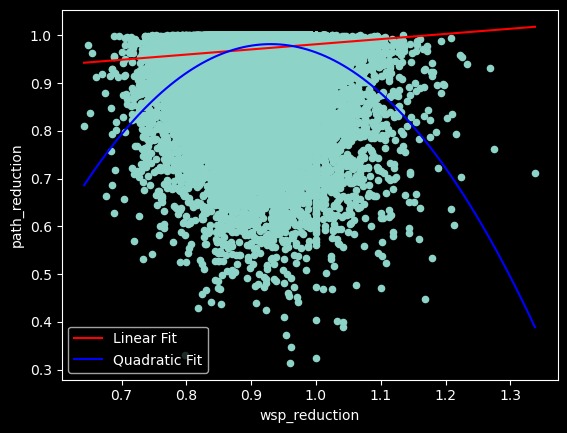

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/1080431629.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.8734199003758012)

In [7]:
reduction_df.plot.scatter("wsp_reduction", "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df["wsp_reduction"].min(), reduction_df["wsp_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [8]:
path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(1, 'path_reduction'))
path_largest = reduction_df.groupby("parent").apply(lambda df: df.nlargest(1, 'path_reduction'))

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/1782352281.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(1, 'path_reduction'))
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/1782352281.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_largest = reduction_df.groupby("parent").apply(lam

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/2391236687.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/2391236687.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     38.20
Date:                Fri, 16 May 2025   Prob (F-statistic):           3.43e-17
Time:                        13:38:24   Log-Likelihood:                 4945.4
No. Observations:                5000   AIC:                            -9885.
Df Residuals:                    4997   BIC:                            -9865.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4773      0.119      4.017      0.000       0.244       0.710
wsp_reduction             0.7789      0.258      3.022      0.003       0.274       1.284
I(wsp_reduction ** 2)    -0.4966      0.139     -3.561      0.000      -0.770      -0.223
==============================================================================
Omnibus:                      530.914   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.115
Skew:                          -0.817   Prob(JB):                    3.23e-166
Kurtosis:                       3.996   Cond. No.                         395.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

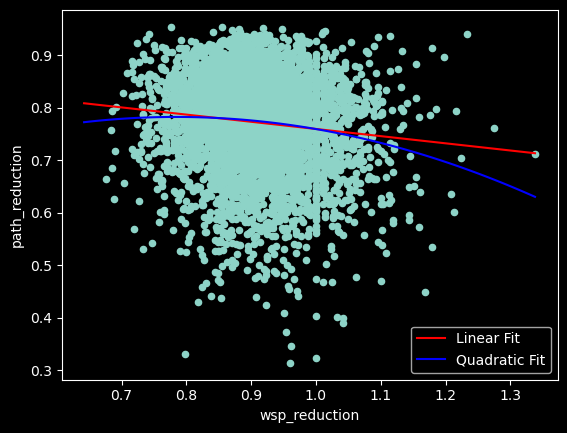

In [9]:
path_smallest.plot.scatter("wsp_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"], sm.add_constant(path_smallest["wsp_reduction"])).fit()

x = np.linspace(reduction_df["wsp_reduction"].min(), reduction_df["wsp_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

results2 = smf.ols(formula="path_reduction ~ wsp_reduction + I(wsp_reduction**2)", data=path_smallest).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')
plt.legend()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     63.58
Date:                Fri, 16 May 2025   Prob (F-statistic):           1.90e-15
Time:                        13:38:24   Log-Likelihood:                 4939.1
No. Observations:                5000   AIC:                            -9874.
Df Residuals:                    4998   BIC:                            -9861.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8967      0.016     57.307      0.000       0.866       0.927
wsp_reduction    -0.1369      0.017     -7.973      0.000      -0.171      -0.103
==============================================================================
Omnibus:                      532.668   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.718
Skew:                          -0.821   Prob(JB):                    3.94e-166
Kurtosis:                       3.979   Cond. No.                         24.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

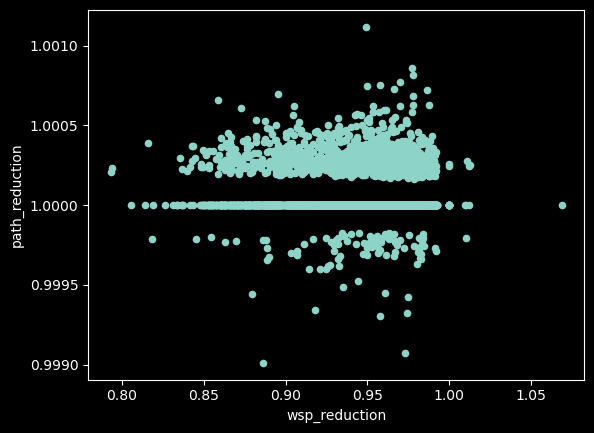

In [10]:
path_largest.plot.scatter("wsp_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"], sm.add_constant(path_smallest["wsp_reduction"])).fit()
results.summary()

## How much does the wsps on a specific point actually matter

In [11]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["point_specific_wsp", "point_specific_wsp_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                 4.848e+04
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        13:38:24   Log-Likelihood:             1.5690e+05
No. Observations:              100000   AIC:                        -3.138e+05
Df Residuals:                   99998   BIC:                        -3.138e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8347      0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                 2.563e+04
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        13:38:24   Log-Likelihood:             1.5783e+05
No. Observations:              100000   AIC:                        -3.157e+05
Df Residuals:                   99997   BIC:                        -3.156e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8478      0.001   1199.640      0.000       0.846       0.849
point_specific_wsp       0.0052      0.000     44.492      0.000       0.005       0.005
point_specific_wsp_B     0.0045      0.000     43.326      0.000       0.004       0.005
==============================================================================
Omnibus:                    58247.630   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           714247.871
Skew:                          -2.600   Prob(JB):                         0.00
Kurtosis:                      15.016   Cond. No.                         85.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2) + point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                 3.850e+04
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        13:38:24   Log-Likelihood:             1.6569e+05
No. Observations:              100000   AIC:                        -3.314e+05
Df Residuals:                   99997   BIC:                        -3.313e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                 2.575e+04
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        13:38:24   Log-Likelihood:             1.7254e+05
No. Observations:              100000   AIC:                        -3.451e+05
Df Residuals:                   99995   BIC:                        -3.450e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6055      0.002    312.667      0.000       0.602       0.609
point_specific_wsp               0.0227      0.000     52.896      0.000       0.022       0.024
I(point_specific_wsp ** 2)      -0.0008   1.64e-05    -46.727      0.000      -0.001      -0.001
point_specific_wsp_B             0.0320      0.000    106.945      0.000       0.031       0.033
I(point_specific_wsp_B ** 2)    -0.0011   1.29e-05    -84.334      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    36379.375   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           358846.395
Skew:                          -1.470   Prob(JB):                         0.00
Kurtosis:                      11.802   Cond. No.                     4.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/3262848167.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


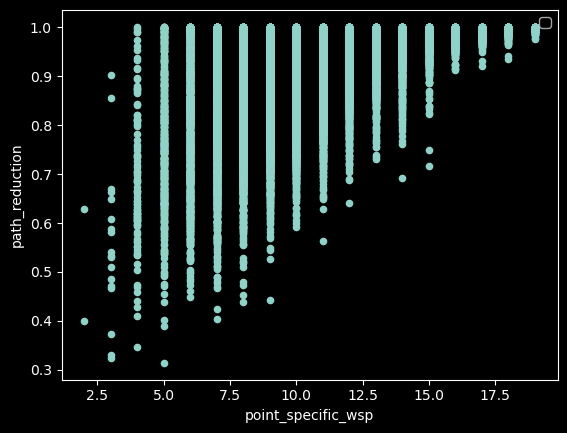

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_32129/3262848167.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.8346763652352442)

In [13]:
reduction_df.plot.scatter("point_specific_wsp", "path_reduction")
# Plot the first fitted model
# results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
# x = np.linspace(reduction_df["point_specific_wsp"].min(), reduction_df["point_specific_wsp"].max(), 100)
# y = results.params[0] + (results.params[1] * x)
# plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
# results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
# y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
# plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_91298/631633804.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)


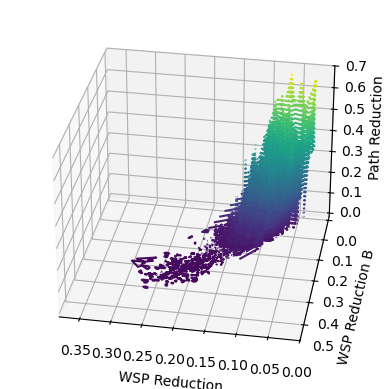

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
x = np.linspace(reduction_df["point_specific_wsp_weighted"].min(), reduction_df["point_specific_wsp_weighted"].max(), 100)
y = np.linspace(reduction_df["point_specific_wsp_weighted_B"].min(), reduction_df["point_specific_wsp_weighted_B"].max(), 100)
X, Y = np.meshgrid(x, y)
Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)
# ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
# Plot the scatter points
# ax.scatter(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], color='r', alpha=0.1)
ax.tricontour(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], 40, cmap='viridis')
ax.set_xlabel('WSP Reduction')
ax.set_ylabel('WSP Reduction B')
ax.set_zlabel('Path Reduction')

ax.view_init(azim=100, elev=30)

plt.show()

<Axes: >

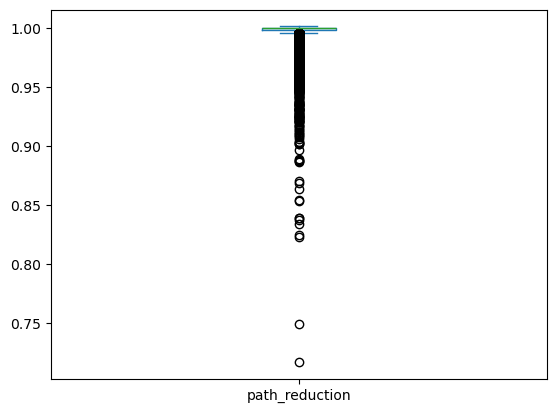

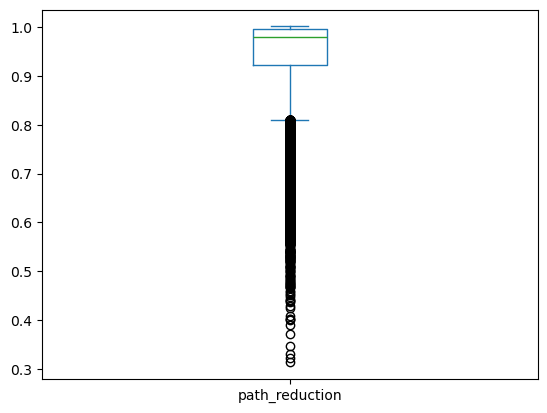

In [15]:
median = reduction_df['point_specific_wsp'].median()

reduction_df[reduction_df['point_specific_wsp'] > median].plot.box(y='path_reduction')
reduction_df[reduction_df['point_specific_wsp'] < median].plot.box(y='path_reduction')

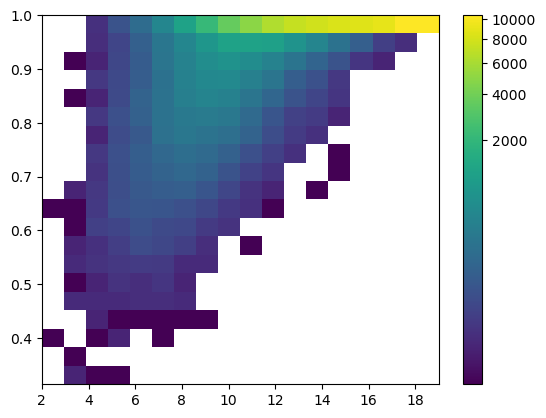

In [16]:
h = plt.hist2d(reduction_df["point_specific_wsp"], reduction_df["path_reduction"], bins=(18,20), cmin=1, norm=PowerNorm(0.25))
plt.colorbar(h[3])

## How well do other geometric tools work for this

In [35]:
variable = "point_maximum_cost_weighted"

results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[variable])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                 4.435e+04
Date:                Tue, 18 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:44:57   Log-Likelihood:             1.5549e+05
No. Observations:              100000   AIC:                        -3.110e+05
Df Residuals:                   99998   BIC:                        -3.110e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.1238      0.001   1522.574      0.000       1.122       1.125
point_maximum_cost_weighted    -0.5878      0.003   -210.584      0.000      -0.593      -0.582
==============================================================================
Omnibus:                    52041.230   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           511892.201
Skew:                          -2.315   Prob(JB):                         0.00
Kurtosis:                      13.071   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
results2 = smf.ols(formula=f"path_reduction ~ {variable} + I({variable}**2)", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                 2.987e+04
Date:                Tue, 18 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:44:57   Log-Likelihood:             1.6056e+05
No. Observations:              100000   AIC:                        -3.211e+05
Df Residuals:                   99997   BIC:                        -3.211e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.8394      0.003    295.374      0.000       0.834       0.845
point_maximum_cost_weighted             1.5332      0.021     74.032      0.000       1.493       1.574
I(point_maximum_cost_weighted ** 2)    -3.7591      0.036   -103.267      0.000      -3.830      -3.688
==============================================================================
Omnibus:                    46136.273   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           455943.213
Skew:                          -1.978   Prob(JB):                         0.00
Kurtosis:                      12.684   Cond. No.                         282.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_91298/1114625799.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_91298/1114625799.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


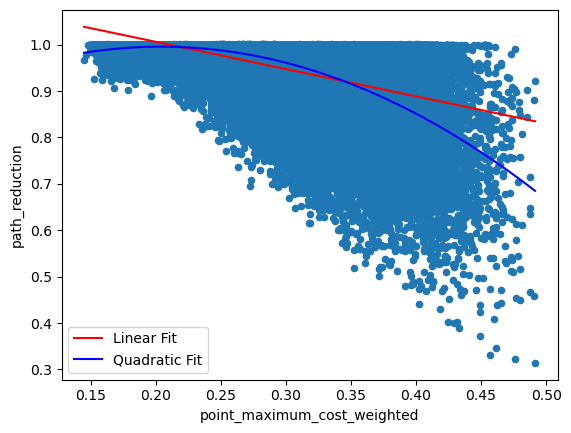

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_91298/1114625799.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


1.1238436087493993

In [37]:
reduction_df.plot.scatter(variable, "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df[variable].min(), reduction_df[variable].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [38]:
results2 = smf.ols(formula=f"optimal_percent ~ point_specific_wsp_weighted + I(point_specific_wsp_weighted**2) + point_average_cost_weighted + I(point_average_cost_weighted**2) + point_maximum_cost_weighted + point_maximum_cost_weighted + I(point_maximum_cost_weighted**2) + point_minimum_cost_weighted", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        optimal_percent   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                 5.492e+04
Date:                Tue, 18 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:44:58   Log-Likelihood:             1.7761e+05
No. Observations:              100000   AIC:                        -3.552e+05
Df Residuals:                   99992   BIC:                        -3.551e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.1959      0.004     54.888      0.000       0.189       0.203
point_specific_wsp_weighted             0.3408      0.026     13.040      0.000       0.290       0.392
I(point_specific_wsp_weighted ** 2)    -0.6970      0.070    -10.024      0.000      -0.833      -0.561
point_average_cost_weighted            -1.7274      0.013   -134.323      0.000      -1.753      -1.702
I(point_average_cost_weighted ** 2)     5.5312      0.041    136.290      0.000       5.452       5.611
point_maximum_cost_weighted            -1.3099      0.019    -70.649      0.000      -1.346      -1.274
I(point_maximum_cost_weighted ** 2)     2.6222      0.033     78.655      0.000       2.557       2.688
point_minimum_cost_weighted             1.8914      0.007    273.400      0.000       1.878       1.905
==============================================================================
Omnibus:                    43276.603   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3957237.200
Skew:                           1.165   Prob(JB):                         0.00
Kurtosis:                      33.730   Cond. No.                         603.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
pca = sm.PCA(reduction_df[["point_specific_wsp_weighted", "point_average_cost_weighted", "point_maximum_cost_weighted", "point_minimum_cost_weighted"]][:5000].T)

pca.factors

,comp_0,comp_1,comp_2,comp_3
point_specific_wsp_weighted,-0.153908,-0.847123,-0.093244,-1.766783
point_average_cost_weighted,0.247779,0.333726,-0.759758,0.781146
point_maximum_cost_weighted,-0.721662,0.396735,0.267965,-1.104263
point_minimum_cost_weighted,0.627791,0.116662,0.585037,2.156126


<Axes: xlabel='point_specific_wsp_weighted', ylabel='point_maximum_cost_weighted'>

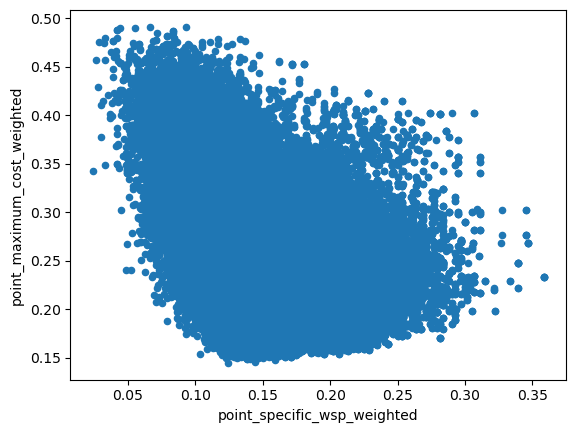

In [40]:
reduction_df.plot.scatter("point_specific_wsp_weighted", "point_maximum_cost_weighted")